# Viscolelasticity Example

In this notebook we provide an example of the DeepMoD algorithm by applying it to the stress response of a material as a result of a dynamic strain application. The data is synthetic and generated outside of this notebook.

We start by importing the required libraries and setting the plotting style:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('../src')
from deepymod_torch.library_function import mech_library
from deepymod_torch.DeepMod import DeepMoD, Not_DeepMoD
from deepymod_torch.VE_params import coeffs_from_model_params, model_params_from_coeffs

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

Next we configure some known facts about the input manipulation. In this example we modelled a scenario when strain was the independant variable under our control, and the analytical expression defining this manipulation was a sinc function. The input function is written as a callable lambda function and uses PyTorch functions as the function will be called PyTorch tensors.

In [2]:
Input_Type = 'Strain'
Input_Function = lambda time_data: torch.sin(time_data)/time_data

Next we load the data. For DeepMoD, we do not need to load the strain data but we will load it just to plot it.

> Note: using this strain data directly will not allow us to calculated derivatives as PyTorch needs to track strain from teh orginal time data and know its history.

In [3]:
data = np.loadtxt('../data/StressStrain/Strain Sinc E[1, 1, 1] V[1.25, 2.5].csv', delimiter=',')
time_Array, strain_array, Stress_Array = data[:,0:1], data[:,1:2], data[:,2:]

Let's plot this data so taht we know what we are looking at

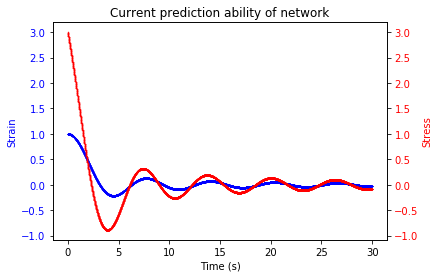

In [4]:
fig, ax1 = plt.subplots()
plt.title('Current prediction ability of network')
ax1.set_xlabel('Time (s)')
colour = 'blue'
ax1.set_ylabel('Strain', color=colour)
ax1.plot(time_Array, strain_array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax1.tick_params(axis='y', labelcolor=colour)
ax2 = ax1.twinx()
colour = 'red'
ax2.set_ylabel('Stress', color=colour)
ax2.plot(time_Array, Stress_Array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax2.tick_params(axis='y', labelcolor=colour)
ax1.set_ylim(ax2.get_ylim())
plt.show()

To show that DeepMoD does not need a huge amount of data points, and also to reduce computational time, we will randomly pick 1000 data points from our sample data.

In [5]:
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_Array.size)
reduced_time_array = time_Array[reordered_row_indices, :][:number_of_samples]
reduced_stress_array = Stress_Array[reordered_row_indices, :][:number_of_samples]

The data is placed into PyTorch tensors. As we will want to know derivatives with respect to time, we must flag that `time_Tensor` requires gradient tracking.

In [6]:
time_Tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
Stress_Tensor = torch.tensor(reduced_stress_array, dtype=torch.float32)

Next we configure our parameters for the running of DeepMoD.

`optim_config` is rather standard.

In [7]:
optim_config = {'lambda': 10**-5, 'max_iterations': 20000}

`network_config` indicates that we have one input data series (time) and one output data series (stress). The network is relatively large as we are trying to fit a semi-periodic function.

In [8]:
network_config = {'input_dim': 1, 'hidden_dim': 15, 'layers': 5, 'output_dim': 1}

`lib_config` contains a large number of elements that require explanation.

- `mech_library` is the name given to the library function imported at the top of the notebook. This function will allow the calculation of the derivatives of strain and stress from the zeroth order through to the maximum order specified by `diff_order`. It also performs the organisation needed to place this data in $\Theta$.

- `coeff_sign` mandates that the initial guesses at the coefficients are all positive. The variability in the set of equations we are trying to fit allows for known signs on all the coefficients. Strain coefficients will be negative always, and stress positive, but as this is taken into account by the library function, DeepMoD is effectively only asked to find the magnitude of these values.

- The remaining two elements are simply the parameters we defined near the beginning.

In [9]:
lib_config = {'type': mech_library, 'diff_order': 3, 'coeff_sign': 'positive', 'input_type': Input_Type, 'input_expr': Input_Function}

With this organisation completed, we can now use the DeepMoD neural network to solve the equation relating stress and strain.

Before doing so however, it useful to know the values of the coefficients that DeepMoD should find. We can do this using a function written for this purpose:
> Will not work without sympy

In [10]:
coeffs_from_model_params([1, 1, 1], [1.25, 2.5])

[0.266666666666667,
 0.833333333333333,
 0.800000000000000,
 2.00000000000000,
 0.833333333333333]

Now, let's run DeepMoD.

In [11]:
#network = Not_DeepMoD(time_Tensor, Stress_Tensor, network_config, lib_config, optim_config)

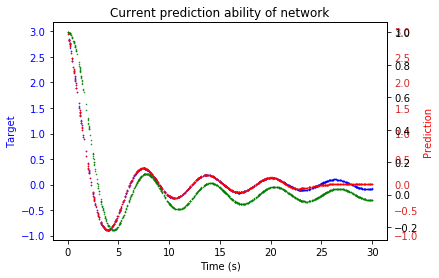

Epoch | Total loss | MSE | PI | L1 
6750 1.1E-03 9.8E-04 1.0E-04 4.8E-05
tensor([[ 0.8355],
        [ 1.3037],
        [ 0.9936],
        [ 0.1760],
        [ 0.0092],
        [ 0.2759],
        [-0.0283]], requires_grad=True)
lrs are 0.0025 0.001
Time elapsed: 18.0 minutes 30.975459098815918 seconds


KeyboardInterrupt: 

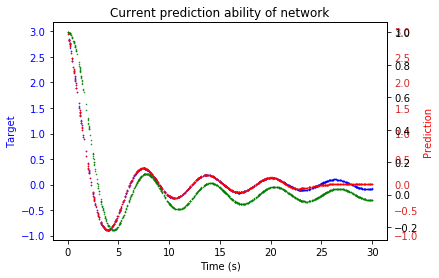

In [12]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD(time_Tensor, Stress_Tensor, network_config, lib_config, optim_config)

To make sense of these coefficients and relate them to the best fit model paramters, we take only `sparse_coeff_vector` and submit this to a simultaneous equations solving algorithm written:
>Will not run without sympy

In [ ]:
Model_Params = model_params_from_coeffs(sparse_coeff_vector)
Model_Params